In [1]:
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.4f}'.format

#my libraries
from wrangle import get_connection, get_zillow_data, handle_missing_values, remove_columns, wrangle_zillow, remove_outliers, train_validate_test_split, get_hist, get_box
from explore import explore_univariate, exp_bivariate_categorical, exp_bivariate_continuous, exp_multivariate, exp_bivariate_categorical, plot_against_target
import evaluate
import model
import env

#library imports
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Statistical Tests
import scipy.stats as stats

#alpha
alpha = .05

In [3]:
df = get_zillow_data()
df.head(2)

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,id,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1727539,NaN,...,0,0.0256,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1387261,NaN,...,1,0.0556,2017-01-01,None,None,None,None,Single Family Residential,None,None


In [4]:
df = wrangle_zillow(df)
df.head(2)

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror
0,3,4,3100,6059,"33,634,931.0000","-117,869,207.0000",4506,1023282,0.0256,Orange,23,0.0108,330,0.0256
1,1,2,1465,6111,"34,449,266.0000","-119,281,531.0000",12647,464000,0.0556,Ventura,54,0.0122,316,0.0556


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,"71,359.0000",2.2019,0.9279,1.0000,2.0000,2.0000,3.0000,13.0000
bedrooms,"71,359.0000",3.0197,1.0044,1.0000,2.0000,3.0000,4.0000,11.0000
sqft,"71,359.0000","1,754.1957",929.5145,360.0000,"1,167.0000","1,514.0000","2,068.0000","21,929.0000"
county_code,"71,359.0000","6,049.2161",20.7240,"6,037.0000","6,037.0000","6,037.0000","6,059.0000","6,111.0000"
latitude,"71,359.0000","34,004,489.6257","269,699.7471","33,339,527.0000","33,804,158.0000","34,016,110.0000","34,176,039.5000","34,818,767.0000"
longitude,"71,359.0000","-118,194,442.2134","361,368.7181","-119,475,416.0000","-118,414,000.0000","-118,164,964.0000","-117,913,930.0000","-117,554,636.0000"
lot_size,"71,359.0000","30,533.2153","119,144.3694",236.0000,"6,000.0000","7,746.0000","24,038.0000","6,971,010.0000"
tax_value,"71,359.0000","488,789.2757","634,433.2677","1,000.0000","204,451.5000","357,143.0000","567,889.5000","25,381,250.0000"
logerror,"71,359.0000",0.0167,0.1671,-4.6554,-0.0236,0.0066,0.0383,5.2630
age,"71,359.0000",51.7106,23.1066,5.0000,34.0000,51.0000,67.0000,143.0000


In [6]:
train, validate, test = train_validate_test_split(df)
print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (39960, 14)
validate observations:  (17127, 14)
test observations:  (14272, 14)


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,"39,960.0000",2.2003,0.9274,1.0000,2.0000,2.0000,3.0000,11.0000
bedrooms,"39,960.0000",3.0176,1.0018,1.0000,2.0000,3.0000,4.0000,9.0000
sqft,"39,960.0000","1,750.0468",920.1406,360.0000,"1,164.0000","1,511.0000","2,063.0000","21,929.0000"
county_code,"39,960.0000","6,049.1352",20.6873,"6,037.0000","6,037.0000","6,037.0000","6,059.0000","6,111.0000"
latitude,"39,960.0000","34,006,157.0775","270,219.3238","33,339,527.0000","33,805,933.2500","34,017,078.0000","34,176,343.5000","34,818,767.0000"
longitude,"39,960.0000","-118,194,666.6446","360,797.1647","-119,475,416.0000","-118,412,293.2500","-118,164,455.5000","-117,914,000.0000","-117,557,472.0000"
lot_size,"39,960.0000","31,280.5879","125,323.7730",435.0000,"6,000.0000","7,760.0000","24,833.0000","6,971,010.0000"
tax_value,"39,960.0000","489,204.3517","655,296.9515","1,000.0000","204,000.0000","356,639.0000","565,000.0000","25,381,250.0000"
logerror,"39,960.0000",0.0166,0.1660,-4.6554,-0.0236,0.0066,0.0388,5.2630
age,"39,960.0000",51.7892,23.0847,5.0000,34.0000,51.0000,67.0000,143.0000


# Explore
- We are not going to explore the scaled data at this time, but it is important that the data is scaled before moving into clustering.

- Target Variable: 'log_error'

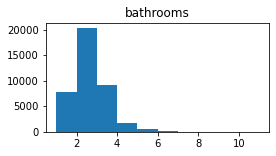

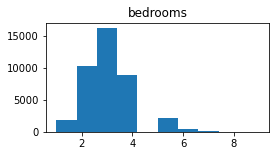

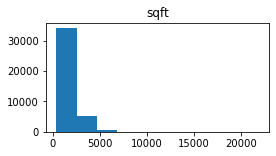

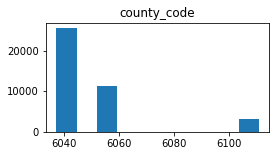

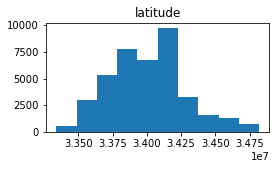

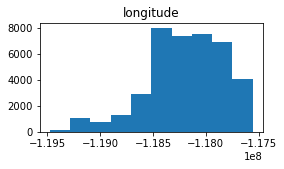

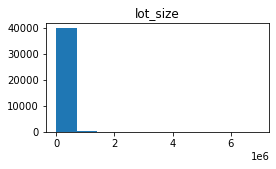

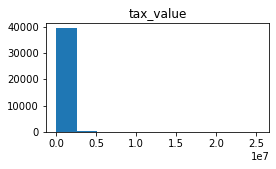

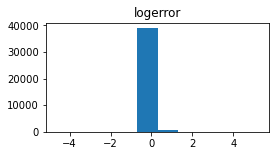

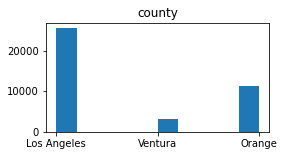

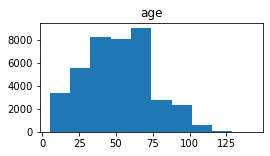

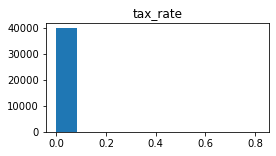

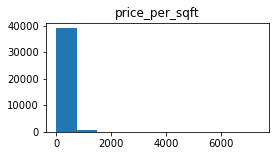

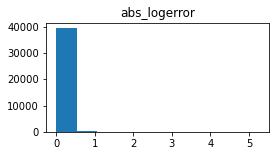

In [8]:
#What are the distributions of each variable (train)
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

##### Takeawyas
- right skewed tax_value, square_feet, and tax_rate
- bit of a left skew on age
- log_error normally distributed

In [9]:
variables = ['bathrooms', 'bedrooms', 'sqft', 'latitude', 'longitude', 'lot_size', 'tax_value', 'age', 
            'tax_rate', 'price_per_sqft', 'county_code']

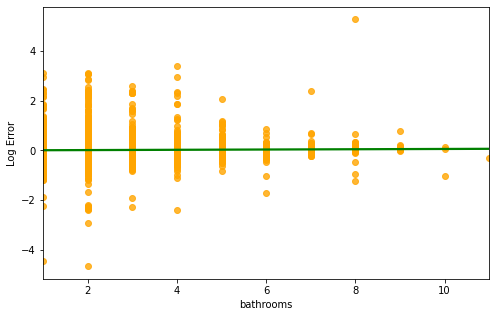

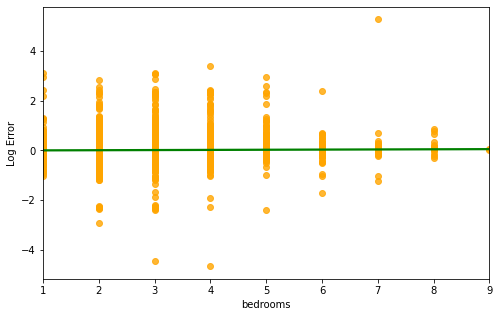

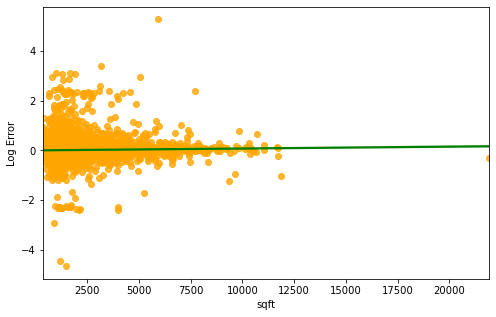

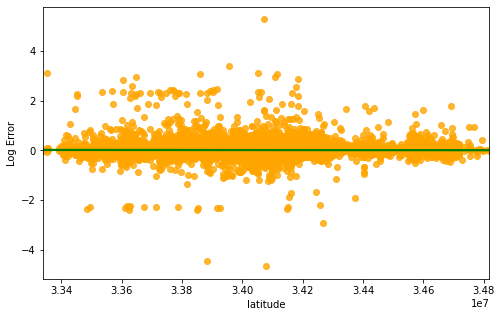

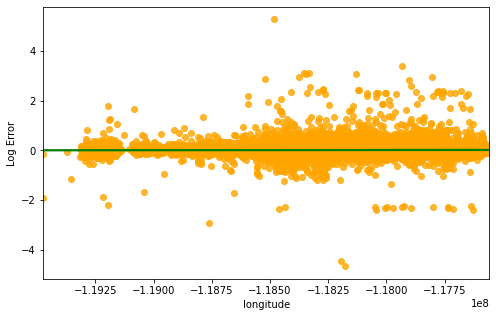

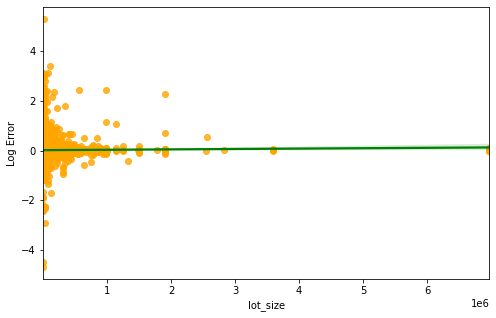

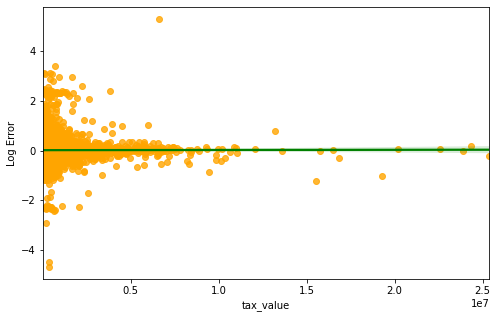

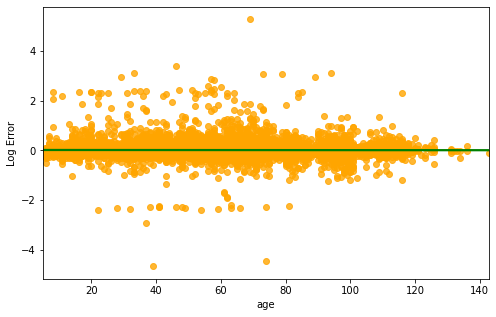

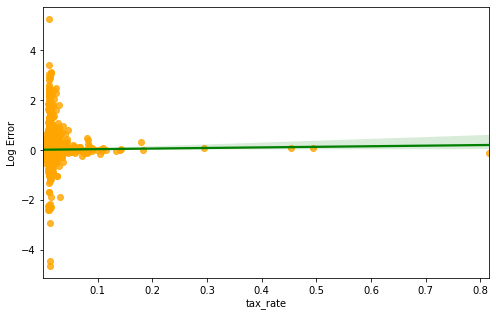

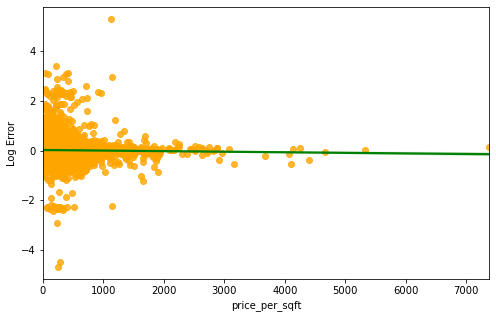

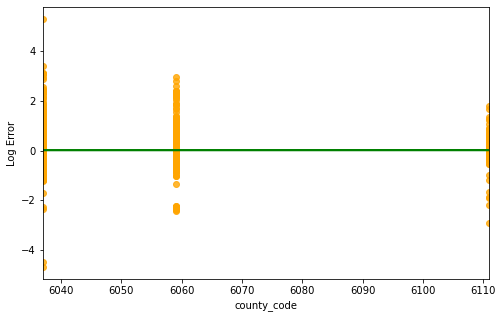

In [10]:
plot_against_target(df = train, target = 'logerror', var_list = variables)

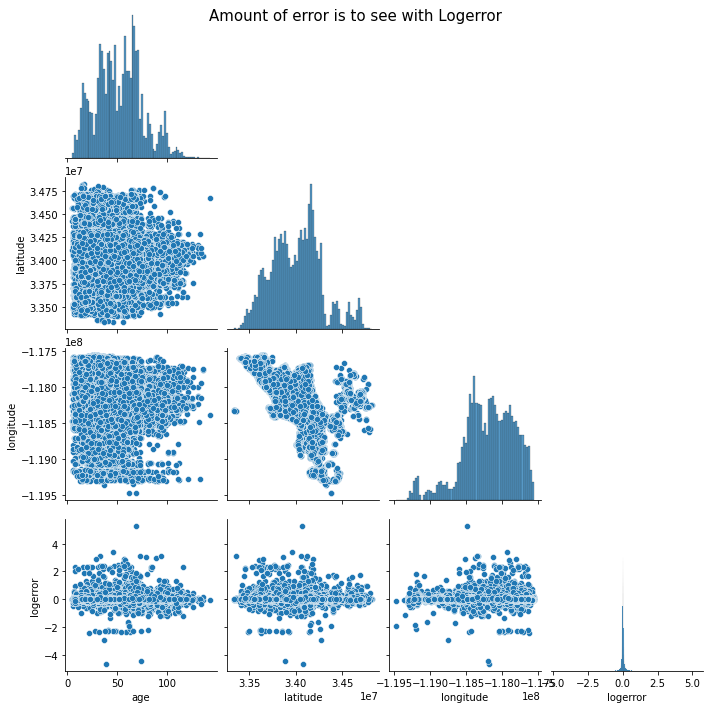

In [11]:
cols = ['age', 'latitude', 'longitude', 'logerror']

sns.pairplot(data = train[cols], corner=True)

plt.suptitle('Amount of error is to see with Logerror', fontsize = 15)

plt.show()

<AxesSubplot:xlabel='county', ylabel='logerror'>

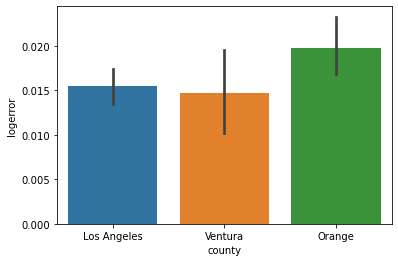

In [12]:
sns.barplot(x="county", y="logerror", data=train)

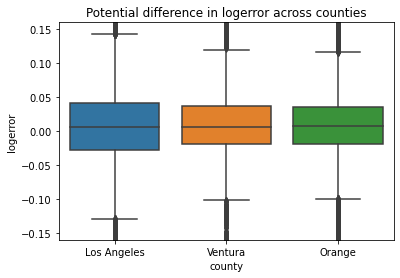

In [13]:
sns.boxplot(train.county, train.logerror)
plt.title('Potential difference in logerror across counties')
plt.ylim(-.16, .16)
plt.show()

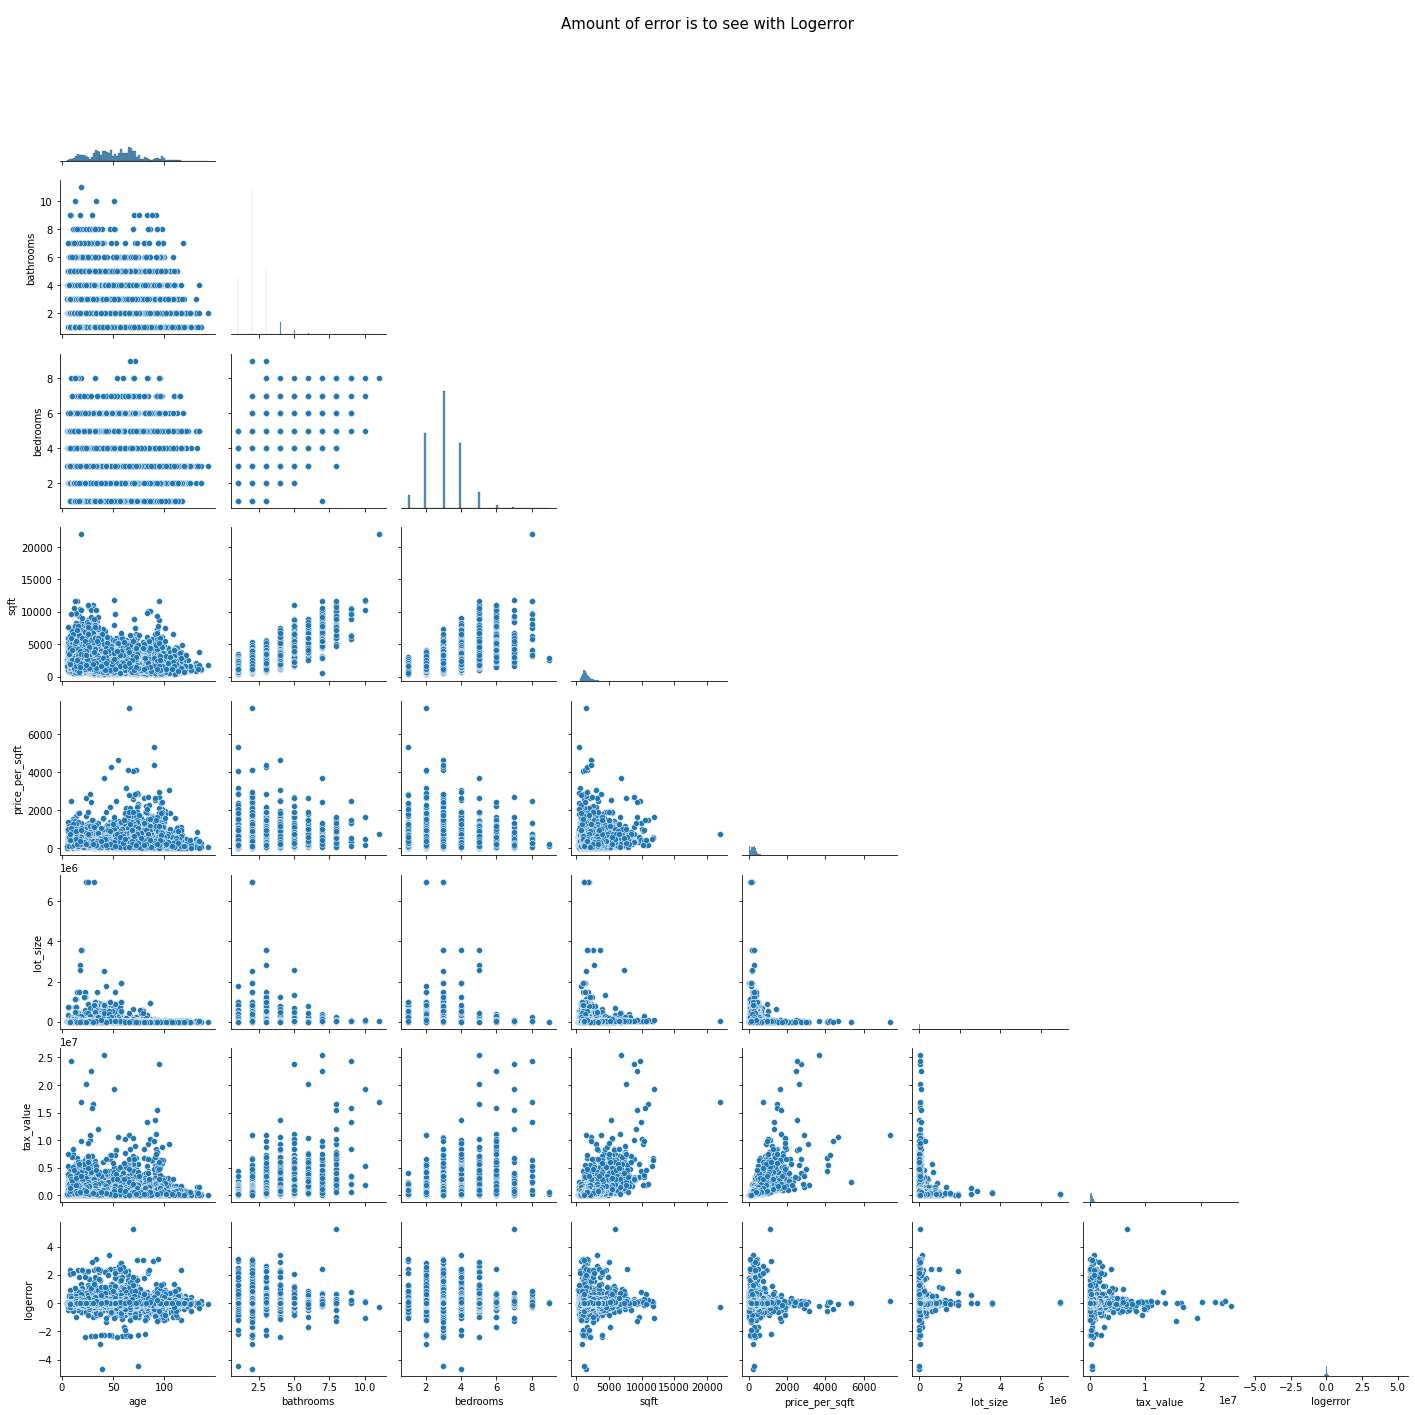

In [14]:
cols = ['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value', 'logerror']

sns.pairplot(data = train[cols], corner=True)

plt.suptitle('Amount of error is to see with Logerror', fontsize = 15)

plt.show()

1. Higher Log errors with homes these features:
    - Homes <60 yrs 
    - <= 4 bathrooms
    - <= 5 bedrooms
    - <= 2500sqft
    - < 1,000 dollars per sqft
    - ?? Lot size
    - ?? Home value

    
    

# Clustering

## Scaled Data

In [15]:
#scale
# Start w/ empty copies to retain the original splits
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()


scaler = MinMaxScaler()
cols = train.drop(columns=["county"]).columns.tolist()


train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.fit_transform(validate[cols])
test_scaled[cols] = scaler.fit_transform(test[cols])

# Add back in the gender column to the dataframes
train_scaled["county"] = train.county.copy()
validate_scaled["county"] = validate.county.copy()
test_scaled["county"] = test.county.copy()

## cluster 1

In [16]:
X = train_scaled[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [17]:
train_scaled.groupby('cluster')['latitude', 'longitude'].mean()

,latitude,longitude
cluster,,
0,0.4391,0.6801
1,0.6085,0.4187
2,0.2351,0.8714
3,0.8685,0.7005


Text(0.5, 1.0, 'Visualizing Cluster Centers')

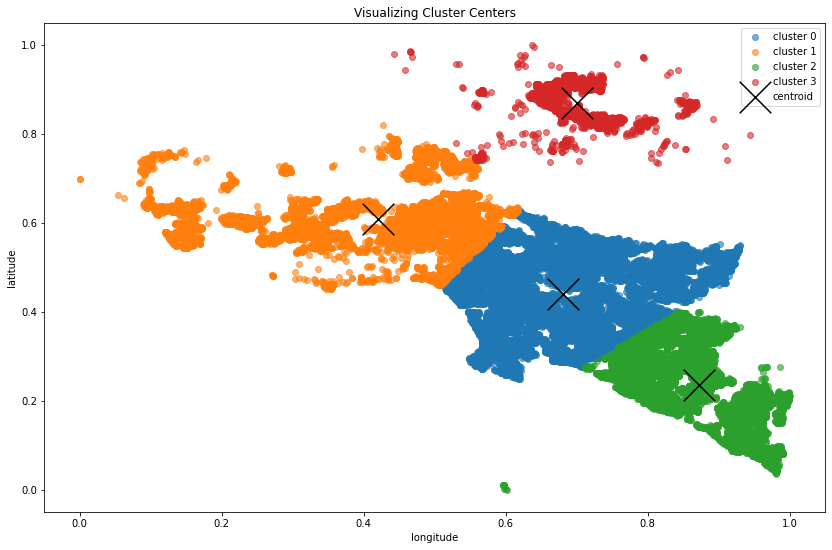

In [18]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.latitude, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='latitude', x='longitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Visualizing Cluster Centers')

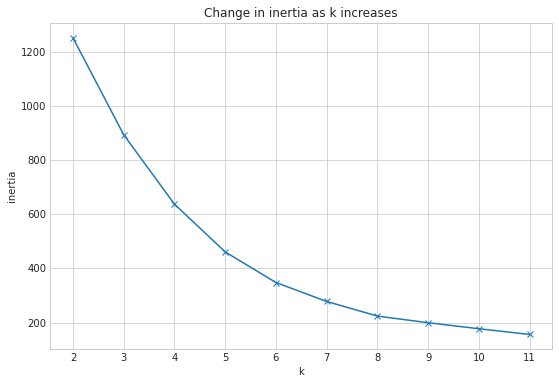

In [19]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## cluster 2 (logerror - age)

In [20]:
X = train_scaled[['logerror', 'age']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [21]:
train_scaled.groupby('cluster')['logerror', 'age'].mean()

,logerror,age
cluster,,
0,0.4713,0.4073
1,0.4710,0.1801
2,0.4703,0.6367


Text(0.5, 1.0, 'Visualizing Cluster Centers')

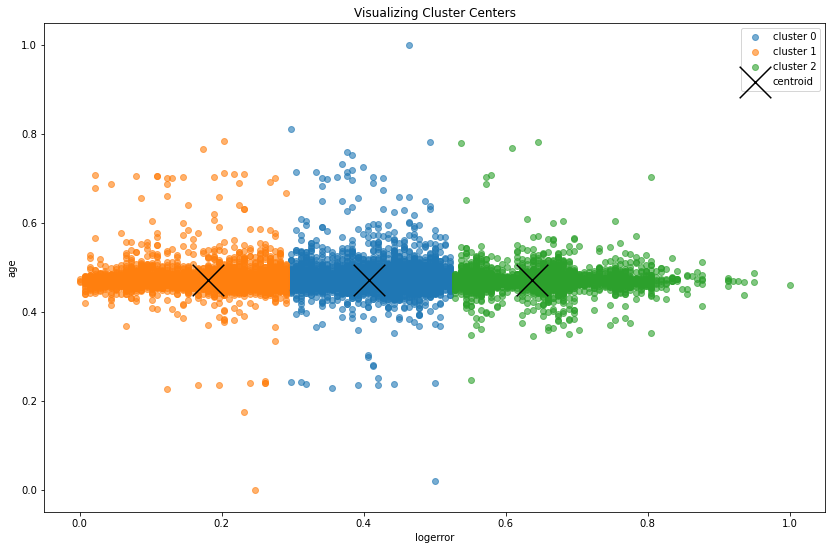

In [22]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.age, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='age', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('age')
plt.title('Visualizing Cluster Centers')

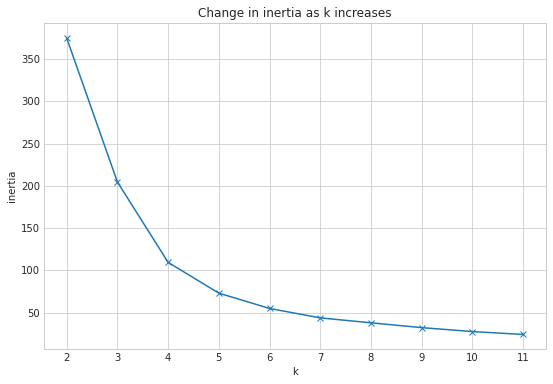

In [23]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Cluster 3 (logerror - bathrooms)

In [24]:
X = train_scaled[['logerror', 'bathrooms']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [25]:
train_scaled.groupby('cluster')['logerror', 'bathrooms'].mean()

,logerror,bathrooms
cluster,,
0,0.4708,0.0000
1,0.4708,0.1000
2,0.4716,0.2342


Text(0.5, 1.0, 'Visualizing Cluster Centers')

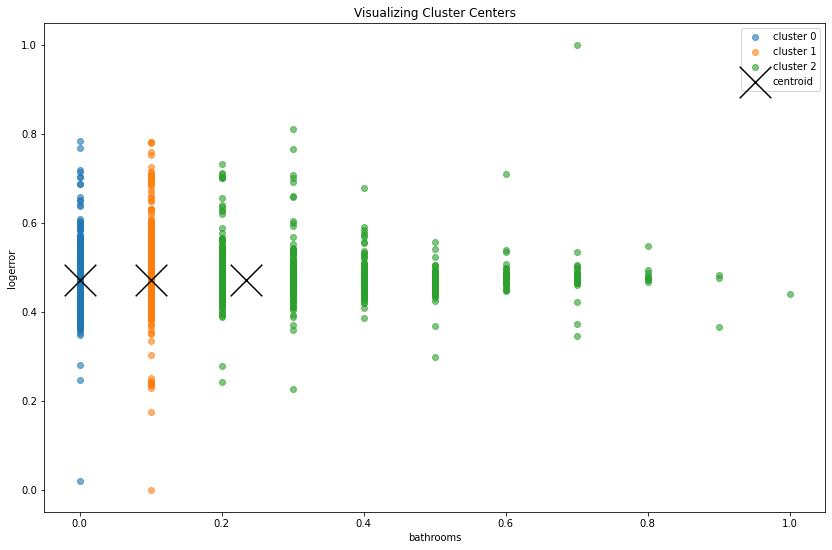

In [26]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.bathrooms, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='bathrooms', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('bathrooms')
plt.ylabel('logerror')
plt.title('Visualizing Cluster Centers')

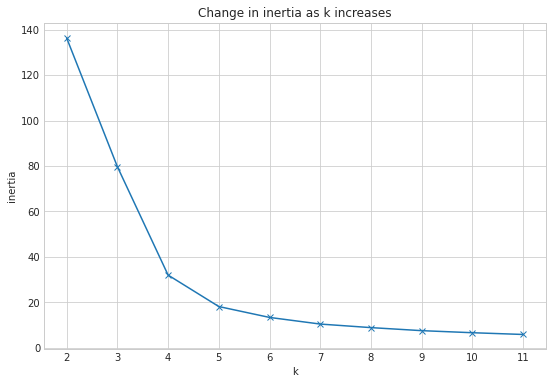

In [27]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Cluster 5

In [28]:
X = train_scaled[['logerror', 'bedrooms']]
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [29]:
train_scaled.groupby('cluster')['logerror', 'bedrooms'].mean()

,logerror,bedrooms
cluster,,
0,0.4720,0.4093
1,0.4707,0.1882


Text(0.5, 1.0, 'Visualizing Cluster Centers')

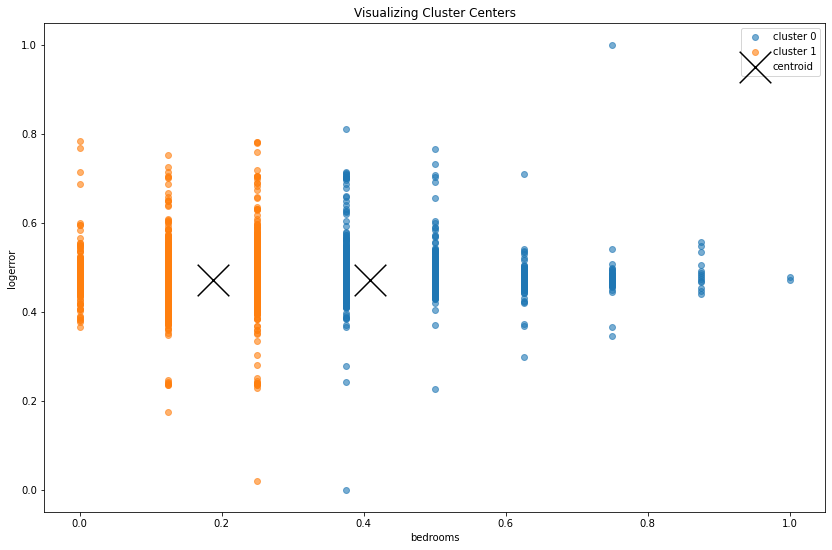

In [30]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.bedrooms, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='bedrooms', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('bedrooms')
plt.ylabel('logerror')
plt.title('Visualizing Cluster Centers')

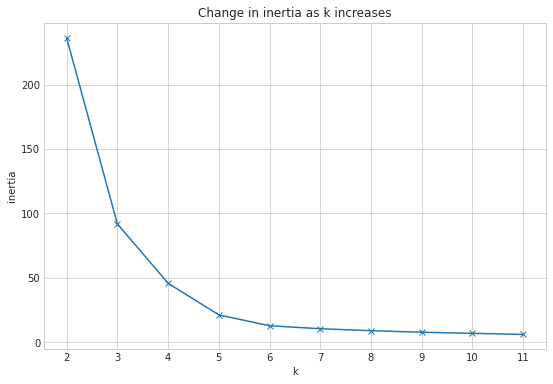

In [31]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Cluster 6

In [32]:
X = train_scaled[['logerror', 'sqft']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [33]:
train_scaled.groupby('cluster')['logerror', 'sqft'].mean()

,logerror,sqft
cluster,,
0,0.4701,0.0374
1,0.4714,0.1328
2,0.4704,0.0744
3,0.4751,0.2518
4,0.6263,0.0621


Text(0.5, 1.0, 'Visualizing Cluster Centers')

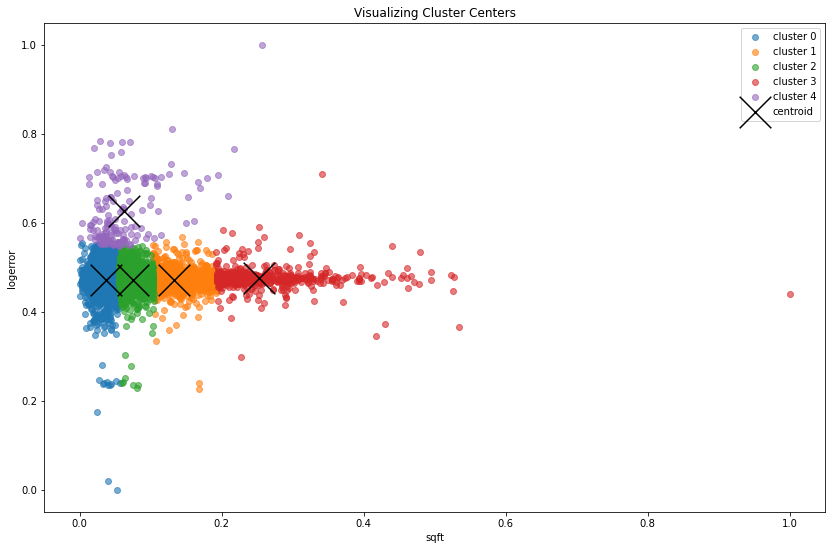

In [34]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.sqft, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('sqft')
plt.ylabel('logerror')
plt.title('Visualizing Cluster Centers')

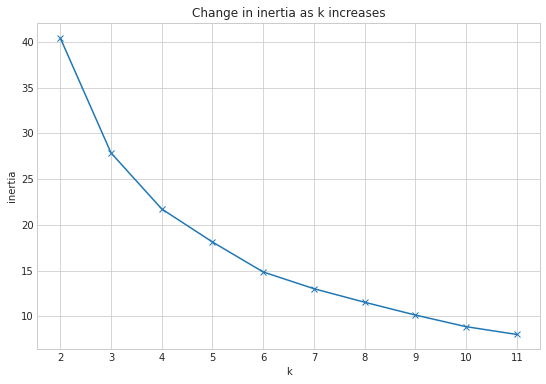

In [35]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Cluster 7

In [36]:
X = train_scaled[['logerror', 'price_per_sqft']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [37]:
train_scaled.groupby('cluster')['logerror', 'price_per_sqft'].mean()

,logerror,price_per_sqft
cluster,,
0,0.4695,0.0528
1,0.4707,0.0211
2,0.4689,0.1571
3,0.5879,0.0314


Text(0.5, 1.0, 'Visualizing Cluster Centers')

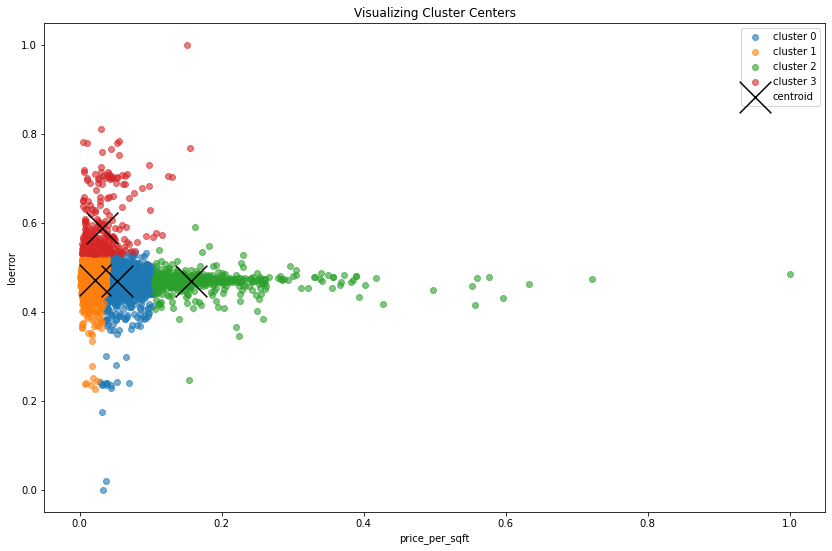

In [38]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.price_per_sqft, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='price_per_sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('price_per_sqft')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

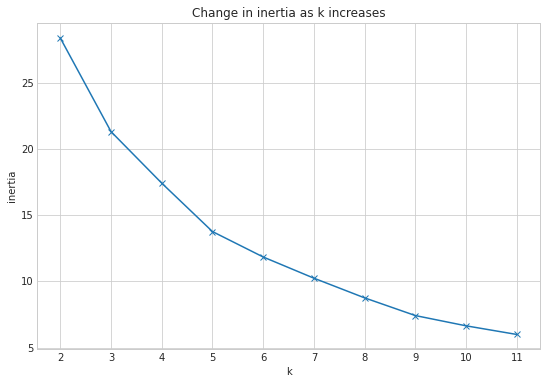

In [39]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Cluster 8

In [40]:
X = train_scaled[['logerror', 'lot_size']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [41]:
train_scaled.groupby('cluster')['logerror', 'lot_size'].mean()

,logerror,lot_size
cluster,,
0,0.4701,0.0028
1,0.4702,0.0805
2,0.4709,0.7844
3,0.5825,0.0052


Text(0.5, 1.0, 'Visualizing Cluster Centers')

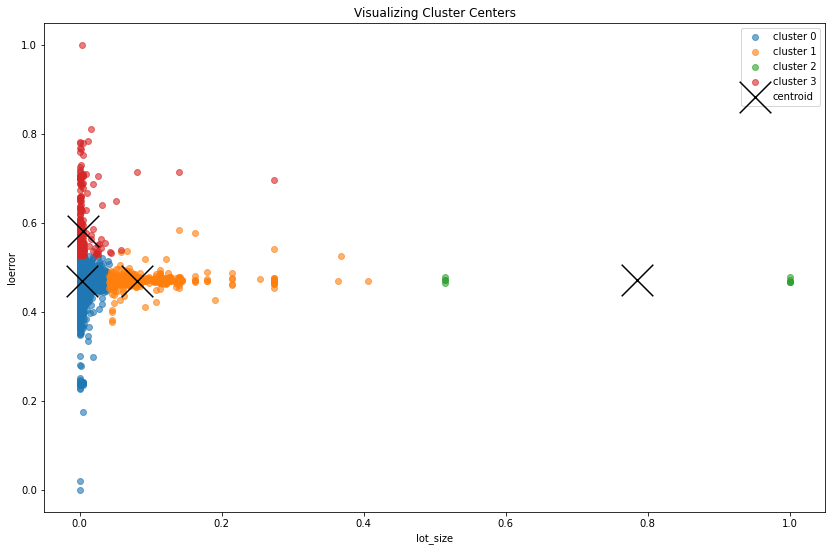

In [42]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.lot_size, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='lot_size', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('lot_size')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

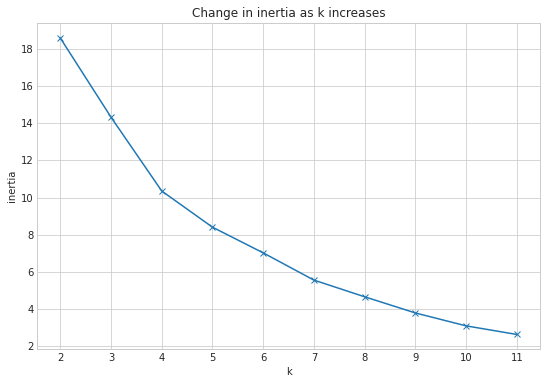

In [43]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Cluster 9 (logerror - home value)

In [44]:
X = train_scaled[['logerror', 'tax_value']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [45]:
train_scaled.groupby('cluster')['logerror', 'tax_value'].mean()

,logerror,tax_value
cluster,,
0,0.4703,0.0146
1,0.4711,0.0695
2,0.4678,0.3261
3,0.6072,0.0189


Text(0.5, 1.0, 'Visualizing Cluster Centers')

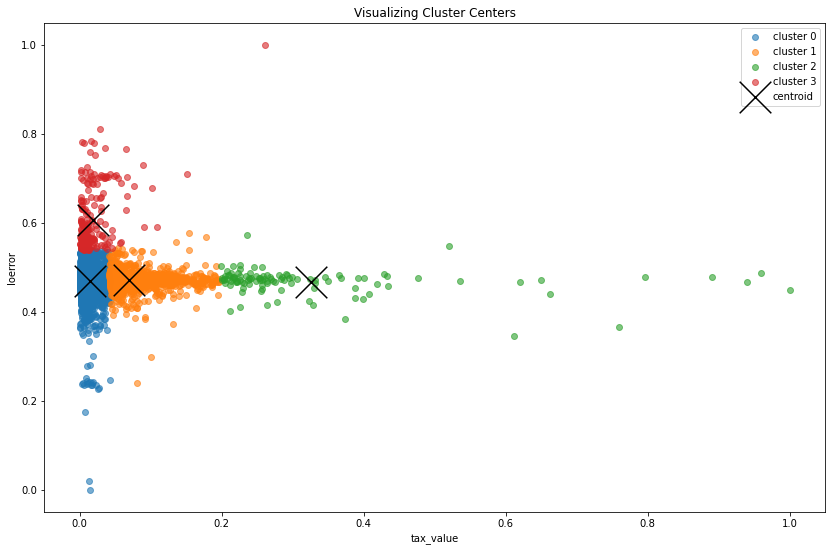

In [46]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.tax_value, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='tax_value', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('tax_value')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

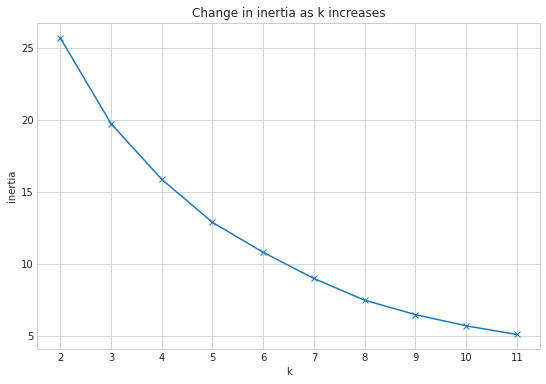

In [47]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Takeaways 
- Is a higher log error dependent on homes over 50 years old? (Cluster - 2)
- Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)
- Is a higher log error dependent on homes who's ppsqft is less 200? (Cluster - 7)
- Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)
- Is a higher log error dependent on less expensive homes? (Cluster - 9)

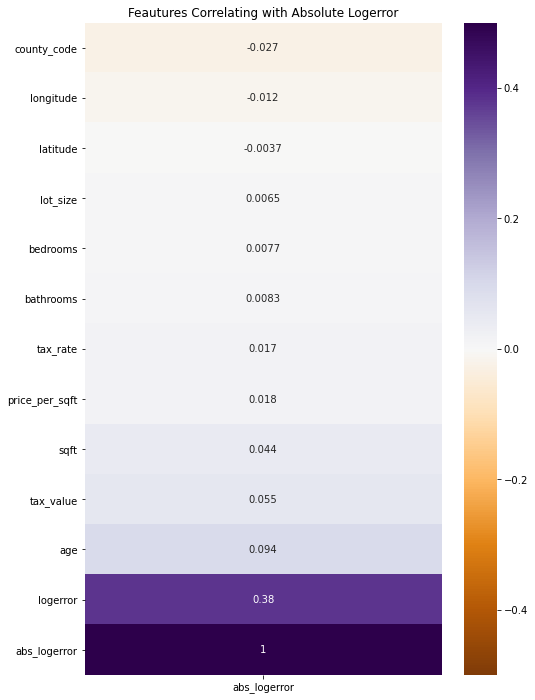

In [48]:
# create heatmap with scaled data
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train.corr()[['abs_logerror']].sort_values(by='abs_logerror', ascending=True), 
                            cmap='PuOr', vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

# Stats testing

##### Is a higher log error dependent on homes over 50 years old? (Cluster - 2)

In [49]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.age > 50)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 39.8021
p     = 0.0000


We reject the null and accept the alternate: Is dependent


##### Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)

In [50]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.sqft > 1000)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 23.0525
p     = 0.0000


We reject the null and accept the alternate: Is dependent


##### Is a higher log error dependent on homes who's ppsqft is less 500? (Cluster - 7)

In [51]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.price_per_sqft < 500)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.3654
p     = 0.5455


We fail to reject the null and accept the null: Is independent


##### Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)

In [52]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.lot_size < 236)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.0000
p     = 1.0000


We fail to reject the null and accept the null: Is independent


##### Is a higher log error dependent on less expensive homes? (Cluster - 9)

In [53]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.tax_value < 205000)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 3.7777
p     = 0.0519


We fail to reject the null and accept the null: Is independent


# Modeling

### Feature Engineering

In [54]:
X_train = train_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_train = train.logerror
X_validate = validate_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_validate = validate.logerror
X_test = test_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_test = test.logerror


In [55]:
evaluate.rfe(X_train,y_train,1)

Index(['sqft'], dtype='object')

In [56]:
evaluate.rfe(X_train,y_train,3)

Index(['sqft', 'price_per_sqft', 'lot_size'], dtype='object')

In [57]:
evaluate.select_kbest(X_train,y_train,1)

Index(['sqft'], dtype='object')

In [58]:
evaluate.select_kbest(X_train,y_train,3)

Index(['bathrooms', 'bedrooms', 'sqft'], dtype='object')

### Regression Modeling

In [59]:
#baseline function calculates baseline and adds columns to the dataframe
evaluate.get_baseline(train,train[['sqft']], train['logerror'])

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror,yhat_baseline,yhat
35417,1,1,792,6037,"33,832,389.0000","-118,088,033.0000",10624,43391,0.0336,Los Angeles,84,0.0210,54,0.0336,0.0166,0.0094
75709,2,4,2060,6037,"33,770,099.0000","-118,103,594.0000",7693,496914,-0.0546,Los Angeles,60,0.0120,241,0.0546,0.0166,0.0189
48946,3,3,2750,6111,"34,176,273.0000","-119,221,020.0000",4121,1068000,0.0075,Ventura,40,0.0125,388,0.0075,0.0166,0.0241
3102,3,3,3412,6059,"33,630,925.0000","-117,647,902.0000",9375,850417,0.1842,Orange,42,0.0101,249,0.1842,0.0166,0.0290
4854,1,1,1013,6037,"33,765,600.0000","-118,182,000.0000",69327,310220,-0.1807,Los Angeles,29,0.0119,306,0.1807,0.0166,0.0111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31583,4,3,3324,6059,"33,900,985.0000","-117,887,039.0000",5800,709615,0.0279,Orange,23,0.0112,213,0.0279,0.0166,0.0284
24870,1,2,1217,6037,"33,882,916.0000","-118,198,985.0000",9323,187101,0.6165,Los Angeles,80,0.0149,153,0.6165,0.0166,0.0126
33566,2,3,2135,6059,"33,666,308.0000","-117,916,527.0000",6720,93341,0.0794,Orange,65,0.0167,43,0.0794,0.0166,0.0195
33858,2,2,1621,6037,"34,045,100.0000","-118,261,000.0000",83398,599719,-0.0043,Los Angeles,38,0.0124,369,0.0043,0.0166,0.0156


In [60]:
evaluate.get_residuals(train, train['logerror'])

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror,yhat_baseline,yhat,residual,residual_baseline
35417,1,1,792,6037,"33,832,389.0000","-118,088,033.0000",10624,43391,0.0336,Los Angeles,84,0.0210,54,0.0336,0.0166,0.0094,-0.0241,-0.0170
75709,2,4,2060,6037,"33,770,099.0000","-118,103,594.0000",7693,496914,-0.0546,Los Angeles,60,0.0120,241,0.0546,0.0166,0.0189,0.0735,0.0712
48946,3,3,2750,6111,"34,176,273.0000","-119,221,020.0000",4121,1068000,0.0075,Ventura,40,0.0125,388,0.0075,0.0166,0.0241,0.0166,0.0091
3102,3,3,3412,6059,"33,630,925.0000","-117,647,902.0000",9375,850417,0.1842,Orange,42,0.0101,249,0.1842,0.0166,0.0290,-0.1551,-0.1676
4854,1,1,1013,6037,"33,765,600.0000","-118,182,000.0000",69327,310220,-0.1807,Los Angeles,29,0.0119,306,0.1807,0.0166,0.0111,0.1917,0.1973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31583,4,3,3324,6059,"33,900,985.0000","-117,887,039.0000",5800,709615,0.0279,Orange,23,0.0112,213,0.0279,0.0166,0.0284,0.0005,-0.0113
24870,1,2,1217,6037,"33,882,916.0000","-118,198,985.0000",9323,187101,0.6165,Los Angeles,80,0.0149,153,0.6165,0.0166,0.0126,-0.6039,-0.5999
33566,2,3,2135,6059,"33,666,308.0000","-117,916,527.0000",6720,93341,0.0794,Orange,65,0.0167,43,0.0794,0.0166,0.0195,-0.0600,-0.0628
33858,2,2,1621,6037,"34,045,100.0000","-118,261,000.0000",83398,599719,-0.0043,Los Angeles,38,0.0124,369,0.0043,0.0166,0.0156,0.0200,0.0209


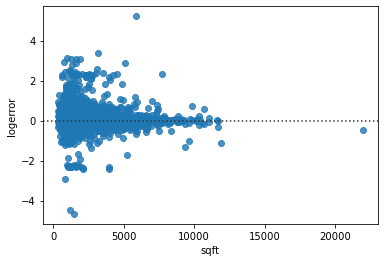

In [61]:
evaluate.plot_residual(train, train[['sqft']], train['logerror'])

In [62]:
evaluate.regression_errors(train, train['logerror'], train.yhat)

(0.027521622737870184,
 1099.7640446052926,
 1.8954852991705304,
 1101.6595299044632,
 0.1658964217150876)

In [63]:
evaluate.baseline_mean_errors(train, train['logerror'], train.yhat_baseline)

(0.027569057304916496, 1101.6595299044632, 0.1660393245737783)

In [64]:
evaluate.better_than_baseline(regression_errors = True, baseline_mean_errors = True)

The model is better then the baseline.


# Baseline Model

In [65]:
model.model_baseline(y_train, y_validate, 'logerror')

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16


## LinearRegression (OLS)

In [66]:
model.linear_regression(y_train, X_train, y_validate, X_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16578663674172942 
Validation/Out-of-Sample:  0.1617184772404811


## LassoLars

In [67]:
model.lassolars(y_train, X_train, y_validate, X_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.1660393245737783 
Validation/Out-of-Sample:  0.16192107522555363


## TPolynomial Regression

In [69]:
model.polynomialregression(y_train, X_train, y_validate, X_validate, X_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.165342362537843 
Validation/Out-of-Sample:  0.7393920899205655


In [70]:
model.plot_actuals_predicted(y_train, y_validate)

AttributeError: module 'model' has no attribute 'plot_actuals_predicted'